In [2]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import shap

In [3]:
classes = {
    "Brain Cancer": {
        0: "Glioma", 1: "Meningioma", 2: "Pituitary Tumor"
    },
    "Breast Cancer": {
        0: "Benign", 1: "Malignant"
    },
    "Cervical Cancer": {
        0: "Dyskeratotic", 1: "Koilocytotic", 2: "Metaplastic", 3: "Parabasal", 4: "Superficial-Intermediat"
    },
    "Kidney Cancer": {
        0: "Normal", 1: "Tumor"
    },
    "Lung and Colon Cancer": {
        0: "Colon Adenocarcinoma", 1: "Colon Benign Tissue", 2: "Lung Adenocarcinoma", 3: "Lung Benign Tissue", 4: "Lung Squamous Cell Carcinoma"
    },
    "Lymphoma": {
        0: "Chronic Lymphocytic Leukemia", 1: "Follicular Lymphoma", 2: "Mantle Cell Lymphoma"
    },
    "Oral Cancer": {
        0: "Normal", 1: "Oral Squamous Cell Carcinoma"
    }
}

In [4]:
def get_top_predicted_indices(predictions, top_n):
    return np.argsort(-predictions).squeeze()[:top_n]

def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names,
    top_n,
    class_indices
):
    #1. Create a model that maps the input image to the activations of the last convolution layer - Get last conv layer's output dimensions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    
    #2. Create another model, that maps from last convolution layer to the final class predictions - This is the classifier model that calculated the gradient
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    
    #3. If top N predictions are to be interospected, Get their Imagenet indices else assign the indices given
    if(top_n > 0):
        last_conv_layer_output = last_conv_layer_model(img_array)
        preds = classifier_model(last_conv_layer_output)
        class_indices = get_top_predicted_indices(preds, top_n)
    else:
        top_n = len(class_indices)
    
    #4. Create an array to store the heatmaps
    heatmaps = []
    #5. Iteratively calculate heatmaps for all classes of interest using GradientTape
    for index in np.arange(top_n):
    
        #6. Watch the last convolution output during the prediction process to calculate the gradients
        #7. Compute the activations of last conv layer and make the tape to watch
        with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)

            #8. Get the class predictions and the class channel using the class index
            preds = classifier_model(last_conv_layer_output)
            class_channel = tf.gather(preds[0], class_indices[index], axis=-1) 
            
        #9. Using tape, Get the gradient for the predicted class wrt the output feature map of last conv layer    
        grads = tape.gradient(
            class_channel,
            last_conv_layer_output
        )
        
        #10. Calculate the mean intensity of the gradient over its feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))    
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        
        #11. Multiply each channel in feature map array by weight importance of the channel
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        #12. The channel-wise mean of the resulting feature map is our heatmap of class activation
        heatmap = np.mean(last_conv_layer_output, axis=-1)

        #13. Normalize the heatmap between [0, 1] for ease of visualization
        max_heatmap = np.max(heatmap)
        if max_heatmap != 0:
            heatmap = np.maximum(heatmap, 0) / max_heatmap
        else:
            heatmap = np.maximum(heatmap, 0)
#                 heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        heatmaps.append({
            "class_id": class_indices[index],
            "heatmap": heatmap
        })

    return heatmaps

In [5]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [6]:
def superimpose_heatmap(image_path, heatmap):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = tf.keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    
    heatmap = tf.keras.preprocessing.image.img_to_array(heatmap)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    superimposed_img = np.uint8(superimposed_img)
    
    return superimposed_img

In [7]:

def display_superimposed_heatmaps(heatmaps, image_path, image_id, pred_class):
    n = len(heatmaps)
    n_rows = (n // 3) + 1 if n % 3 > 0 else n // 3
    plt.rcParams['axes.grid'] = False
    plt.rcParams['xtick.labelsize'] = False
    plt.rcParams['ytick.labelsize'] = False
    plt.rcParams['xtick.top'] = False
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    plt.rcParams['ytick.right'] = False
    plt.rcParams['figure.figsize'] = [30, 15]
    for index in np.arange(n):
        heatmap = heatmaps[index]["heatmap"]
        class_id = heatmaps[index]["class_id"]
        class_name = pred_class
        superimposed_image = superimpose_heatmap(image_path, heatmap)
        plt.subplot(n_rows, 3, index+1)
        plt.title(f"{class_id}, {class_name}", fontsize= 20)
        plt.imshow(superimposed_image)
        
    plt.show()


In [8]:
def predict_class(img, model):
    img = Image.open(img)

    img = img.resize((224, 224))  
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]  # Get the index of the max predicted class
    return predictions, img, predicted_class_idx



# **GRADCAM - 2**

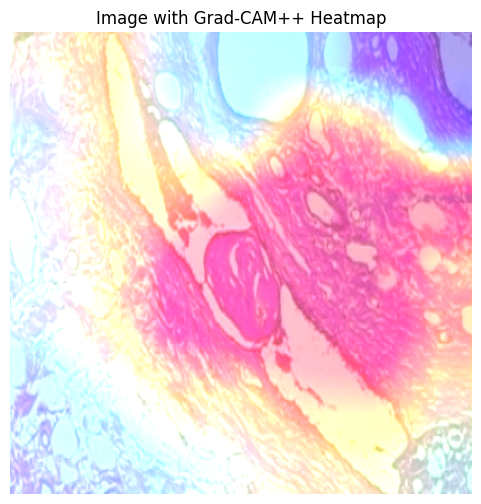

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def grad_cam_plus_plus(model, img_array, layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def apply_heatmap(heatmap, original_img_path, intensity=0.5, colormap=cv2.COLORMAP_JET):
    original_img = cv2.imread(original_img_path)
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.maximum(heatmap_resized, 0)
    heatmap_resized = heatmap_resized / np.max(heatmap_resized)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, colormap)
    superimposed_img = heatmap_resized * intensity + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# Load your model
model = load_model('/kaggle/input/efficient-net/Efficient Net/Breast Cancer  - EfficientNetB0.keras', compile=False)

# Prepare the image
img_path = '/kaggle/input/test-data/test/Breast Cancer/breast_malignant_4202.jpg'
img_array = load_and_preprocess_image(img_path)

# Generate Grad-CAM++ heatmap
heatmap = grad_cam_plus_plus(model, img_array, 'top_activation')  # Specify the last conv layer name

# Overlay and display the heatmap
#overlay_heatmap(heatmap, img_path)

superimposed_img = apply_heatmap(heatmap, img_path)

superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Image with Grad-CAM++ Heatmap')
plt.show()

# If you want to display the image within a Jupyter notebook you can use the following:
# from IPython.display import Image, display
# display(Image('/mnt/data/cervix_cancer_gradcam++.jpg'))

# **SHAP**

In [10]:
def load_background_batch():

    test_dir = '/kaggle/input/test-data/test'
    batch_data = []

    for dirc in os.listdir(test_dir):
        dir_path = os.path.join(test_dir, dirc)
        image_files = os.listdir(dir_path)

        background_data = []

        for img_file in image_files:
            img_path = os.path.join(dir_path, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  
            background_data.append(img_array)

        background_batch = np.vstack(background_data)

        batch_data.append(background_batch)


    return batch_data

In [11]:
def shap_explanation(model, img_array, background):
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(img_array)
    return shap_values

In [12]:

def show_shap(shap_values, img_array, predicted_class_idx, class_names):
    
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)

    # Get the SHAP values for the predicted class
    shap_values_for_predicted_class = shap_values[predicted_class_idx]

    # Plotting
    plt.figure()
    shap.image_plot(shap_values_for_predicted_class, img_array)
    plt.show()
    
    # Print the predicted class
    predicted_class_name = class_names[predicted_class_idx]
    st.warning(f"Model predicted: {predicted_class_name}")

    st.write('Inference for the Prediction: Plot of SHAP values')
    st.pyplot(plt.gcf())

# **RESULT - GRADCAM AND SHAP**

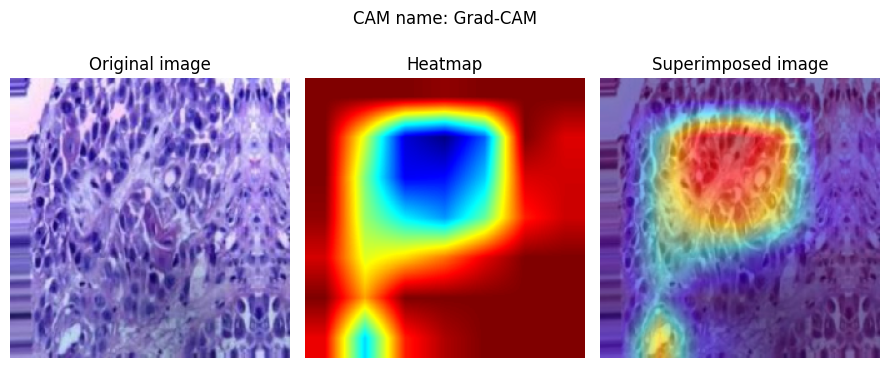

In [10]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

def get_img_array(img_path, size=(224, 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.uint8(array)
    #array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # print(heatmap.shape)
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    # print(heatmap.shape)
    return pred_index.numpy(), heatmap.numpy()


def superimpose(img, cam):

    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.5 + img * 0.5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(
        np.uint8
    )
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img
def plot_org_img_and_cam_heatmap(
    model,
    cam_func,
    superimpose,
#     cls_true,
#     class_to_label,
    cam_name,
    img,
):

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(
        model=model,
        img_array=np.expand_dims(img, axis=0),
        last_conv_layer_name="top_conv",
    )
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title("Original image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("Heatmap")
    axs[1].axis("off")

    axs[2].imshow(superimposed_img)
    axs[2].set_title("Superimposed image")
    axs[2].axis("off")

    title = (
        "CAM name: "
        + cam_name
#         + " / True label: "
#         + class_to_label[cls_true]
#         + " / Predicted label : "
#         + class_to_label[cls_pred]
    )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
# class_dict = {
#     index: class_name for index, class_name in enumerate(class_names)
# }
# print(class_dict)
img_path = '/kaggle/input/test-data/test/Oral Cancer/oral_scc_3542.jpg'
model = load_model('/kaggle/input/efficient-net/Efficient Net/Oral Cancer  - EfficientNetB0.keras', compile=False)
model.layers[-1].activation = None
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=make_gradcam_heatmap,
    superimpose=superimpose,
    #cls_true=np.argmax(valid_labels[4]),
#     class_to_label=class_dict,
    cam_name="Grad-CAM",
    img=get_img_array(img_path),
)

